# Brick Lane Analysis Notebook

Performs exploratory analysis on CSV based datasets
CSV data is generated using notebooks data_capture and data_capture2

In [95]:
# Import Libraries
import re
import requests
import pandas as pd
import numpy as np
import math

from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  # plotting library
%matplotlib inline 
plt.rcParams['figure.figsize'] = [8, 8]

import folium
import seaborn as sns



## Locations of Interest
Use the Nominatum locator to determine long / lat of Brick Lane and Shoreditch

In [96]:


# Get the Longitude and Latitude of Brick Lane
address = 'Brick Lane, London, UK'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
#latitude = 51.522426 
#longitude = -0.0715922


51.522426 -0.0715922


In [97]:
# Get the Longitude and Latitude of Shoreditch
address = 'Shoreditch, London, UK'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)
#latitude = 51.522426 
#longitude = -0.0715922

51.5266694 -0.0798926


## Data Import

In [98]:
# Indian Restaurants with Ratings
all_indian = pd.read_csv("./ratings.csv", index_col = 0)
print('{} unique venues in combined dataset.'.format(all_indian.shape[0]))
all_indian.head()

152 unique venues in combined dataset.


id        name         categories        lat  \
0  5040721ae4b01446aa41d438     Dishoom  Indian Restaurant  51.524515   
1  56465da7498ec6f39fb6dee5   Gunpowder  Indian Restaurant  51.518436   
2  4c712d74fa49a1cdee11a8e3  Dosa World  Indian Restaurant  51.520245   
3  58cafdcece593d315f7bf042  Meraz Cafe  Indian Restaurant  51.520256   
4  52f38b8b498e41cb2f27edcd    Tifinbox  Indian Restaurant  51.516345   

        lng postalCode  rating  
0 -0.076850     E2 7JE     9.4  
1 -0.074732     E1 7NF     8.9  
2 -0.071358     E1 5JL     8.3  
3 -0.071085     E1 5JL     8.8  
4 -0.077195     E1 7DB     8.4

In [99]:
# Entries in the dataset which have a negative rating are unrated and should be dropped
all_indian = all_indian[all_indian.rating>=0]
print('{} unique venues in combined dataset.'.format(all_indian.shape[0]))


100 unique venues in combined dataset.


## Distance Field Creation

In [100]:
# Approximate conversion of lng/lat to metres
# http://en.wikipedia.org/wiki/Lat-lon
km_per_deg_lat = (111132.92 - 559.82 * math.cos( 2 * latitude ) + 1.175 * math.cos( 4 * latitude))/1000
km_per_deg_lon = (111412.84 * math.cos ( latitude ) - 93.5 * math.cos( 3 * latitude ))/1000

# Create a new column for distance
all_indian = all_indian.assign(dist=np.sqrt((km_per_deg_lat*(all_indian.lat-latitude))**2 + (km_per_deg_lon*(all_indian.lng-longitude))**2))
all_indian.head()

id        name         categories        lat  \
0  5040721ae4b01446aa41d438     Dishoom  Indian Restaurant  51.524515   
1  56465da7498ec6f39fb6dee5   Gunpowder  Indian Restaurant  51.518436   
2  4c712d74fa49a1cdee11a8e3  Dosa World  Indian Restaurant  51.520245   
3  58cafdcece593d315f7bf042  Meraz Cafe  Indian Restaurant  51.520256   
4  52f38b8b498e41cb2f27edcd    Tifinbox  Indian Restaurant  51.516345   

        lng postalCode  rating      dist  
0 -0.076850     E2 7JE     9.4  0.261767  
1 -0.074732     E1 7NF     8.9  0.935345  
2 -0.071358     E1 5JL     8.3  0.773459  
3 -0.071085     E1 5JL     8.8  0.775863  
4 -0.077195     E1 7DB     8.4  1.155713

## Exploratory Analyses

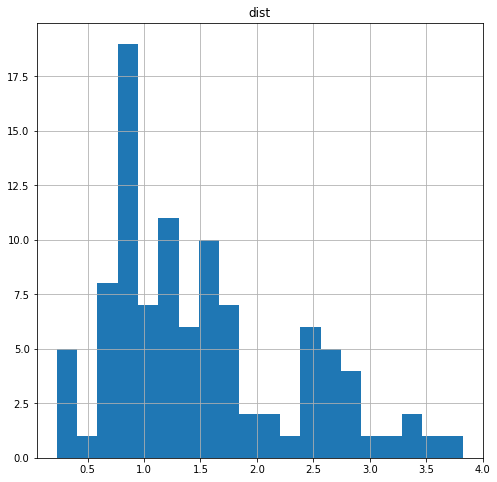

In [101]:

# Basic Histogram of distance from Brick Lane
hist_dist = all_indian.hist(column='dist', bins=20)


## Non-Indian Dataset
Import the data set for non-Indian restaurants.
This is a much large dataset but we want to generate a comparative histogram to the above so we filter the data to distances of 4km from Brick lane. We then generate the bins as a vector and plot both in the same axes.


In [102]:
# Repeat data import for Non-Indian dataset

near_all_indian = all_indian[ all_indian.dist<4 ]
non_indian = pd.read_csv("./non_indian_brick_lane.csv", index_col = 0)
near_non_indian = non_indian[ non_indian.dist<4 ]
#hist_dist = near_non_indian.hist(column='dist', bins=20)


In [103]:
my_bins = np.linspace(0, 4, num=20)

Text(0, 0.5, 'Frequency')

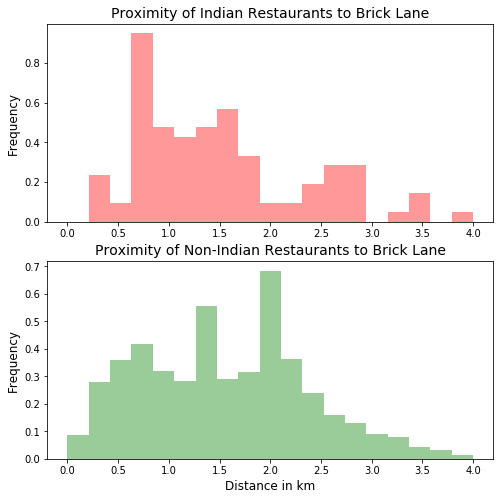

In [104]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

sns.distplot(all_indian['dist'], bins=my_bins, kde=False, norm_hist=True, color='red', label ='Indian Restaurants', ax = ax1)
ax1.set_title("Proximity of Indian Restaurants to Brick Lane", fontsize=14)
ax1.set_xlabel('', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)

sns.distplot(near_non_indian['dist'], bins=my_bins, kde=False, norm_hist=True, color='green', label='Other Restaurants', ax=ax2)
ax2.set_title("Proximity of Non-Indian Restaurants to Brick Lane", fontsize=14)
ax2.set_xlabel('Distance in km', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

In [105]:
non_indian.head()

id                    name  \
0  58188c2b38fab86819349c50               Smokestak   
1  4ac518c0f964a520aba320e3  Hawksmoor Spitalfields   
2  51a62209454ae7b27328f944          Burro e Salvia   
4  4ac518bbf964a5200ca220e3             Beigel Bake   
6  56e94fda498ec86ebeb6fc90           Delamina EAST   

                  categories        lat       lng postalCode      dist  
0                  BBQ Joint  51.523638 -0.072911     E1 6LB  0.142733  
1                 Steakhouse  51.521478 -0.075617     E1 6BJ  0.174489  
2         Italian Restaurant  51.524430 -0.074598     E2 7DP  0.246433  
4                 Bagel Shop  51.524513 -0.071643     E1 6SB  0.232916  
6  Middle Eastern Restaurant  51.521318 -0.075485     E1 6BJ  0.182445

## Exploration of Non-Indian Dataset
Plot the location of the venues using Folium as a first examination of how the dataset looks.

In [106]:
map_non_indian = folium.Map(location=[latitude, longitude], zoom_start=13)
# set color scheme for the clusters


# add markers to the map
markers_colors = []
for lat, lon, nm, cat in zip(non_indian['lat'], non_indian['lng'], non_indian['name'], non_indian['categories']):
    label = folium.Popup(str(nm) + ' ' + str(cat), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=0.0,
        fill=True,
        fill_color=0.5,
        fill_opacity=0.7).add_to(map_non_indian)

map_non_indian


## Explore relationship between proximity to Brick Lane and ratings for Indian Restaurants
Scatter plot is the first tool to look for any correlation between variables.
Annotations added to highlight any interesting facets

Text(3, 6.6, 'Mean = 6.56')

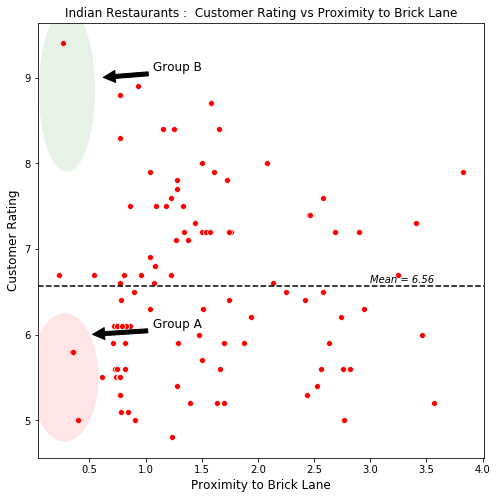

In [107]:
#scatter_rating_dist = all_indian.plot.scatter('dist','rating')
#tips = sns.load_dataset("tips")
from matplotlib.patches import Ellipse
means = all_indian.mean(axis=0)

ax = sns.scatterplot(x="dist", y="rating", color='red', data=all_indian)
#ax = sns.scatterplot(x="dist", y="rating", data=near_non_indian)
ax.set_title('Indian Restaurants :  Customer Rating vs Proximity to Brick Lane')
ax.set_ylabel('Customer Rating', fontsize=12)
ax.set_xlabel('Proximity to Brick Lane', fontsize=12)
el = Ellipse((0.28, 5.5), 0.6, 1.5, facecolor='r', alpha=0.1)
ax.add_artist(el)
el2 = Ellipse((0.3, 8.85), 0.5, 1.9, facecolor='g', alpha=0.1)
ax.add_artist(el2)
ax.annotate('Group A',
            xy=(0.5, 6), xycoords='data', fontsize=12,
            xytext=(1.5, 6.2), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
ax.annotate('Group B',
            xy=(0.6, 9), xycoords='data', fontsize=12,
            xytext=(1.5, 9.2), textcoords='data',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top')
l1=ax.axhline(means['rating'],color='black',ls='--')
ax.text(3, 6.6, 'Mean = 6.56', style='italic')

## Exploration of Clustering

Analysis of geographic clustering in the dataset. 
First attempt uses K means with 4 clusters. Later on we try DBSCAN.

Basic approach is to drop any columns we are not using for clustering and then normalize. In this instance we are using the location and the rating.

In [108]:
# Select the columns of interest and normalize
g3 = all_indian.drop(['postalCode', 'name', 'categories', 'id','dist'], 1)

X = g3.values[:, :]
#X = np.nan_to_num(X)
#cluster_dataset = StandardScaler().fit_transform(X)
from sklearn.preprocessing import MinMaxScaler
cluster_dataset =  MinMaxScaler().fit_transform(X)

In [109]:
# Run K-menas with 4 clusters
kclusters = 4
k_means = KMeans(init="k-means++", n_clusters=kclusters, n_init=12)
k_means.fit(cluster_dataset)

# Merge the cluster labels with the original dataset

all_indian.insert(0, 'cluster', k_means.labels_)

### Exploratory Scatter Plot 1  
This looks for any pattern in clustering that relates the distance from Brick Lane and the Rating
There seems to be some vertical split in close proxity, other clusters seem to be just by distance.

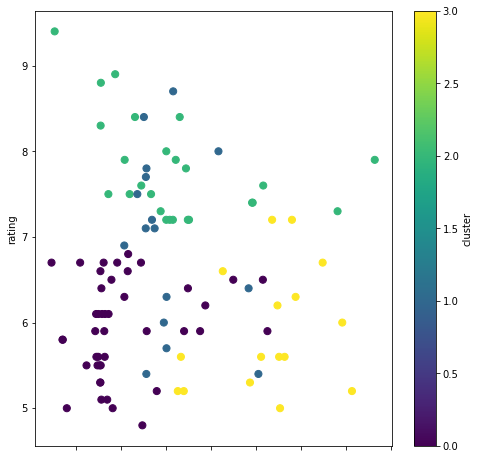

In [110]:
scatter_rating_dist = all_indian.plot.scatter('dist','rating', c='cluster', colormap='viridis', s=50)


### Exploratory Scatter Plot 2  
This now replicates the cluster on the horizontal axis as well as the colour code to make the separtion in rating in the first two clusters more obvious

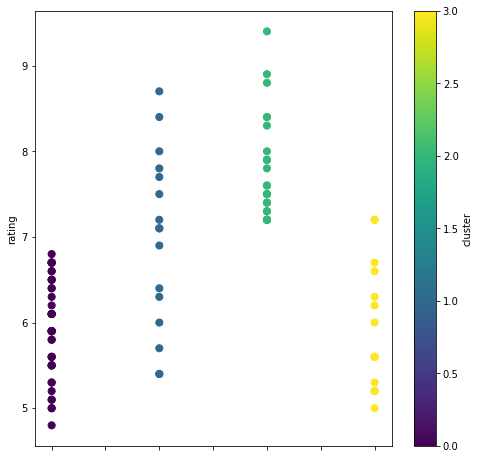

In [111]:
scatter_rating_dist = all_indian.plot.scatter('cluster','rating', c='cluster', colormap='viridis', s=50)


## Location and Rating
Plot the venues on a map of the region, colour coded by rating

In [112]:
import branca
import branca.colormap as cm
colormap = cm.LinearColormap(colors = ['yellow','red'], index = [50,100], vmin=50,vmax=100) 

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=15)
g2 = all_indian


# add markers to the map
markers_colors = []
for lat, lon, nm, rating in zip(g2['lat'], g2['lng'], g2['name'],g2['rating']):
    label = folium.Popup(str(nm)+' '+str(rating), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=0.0,
        fill=True,
        fill_color=colormap(int(rating*10)),
        fill_opacity=0.9).add_to(map_clusters)

colormap = colormap.to_step(index=[5, 6, 7, 8, 9])
colormap.caption = 'Customer Rating'
colormap.add_to(map_clusters)
map_clusters


## Non-Indian Dataset
Explore the dataset of the non Indian restaurants. First by plotting their location on a map of London, just to get a feeling for the extent of the data set

In [113]:
import branca
import branca.colormap as cm
colormap = cm.LinearColormap(colors = ['yellow','red'], index = [50,100], vmin=50,vmax=100) 

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
g2 = near_non_indian


# add markers to the map
markers_colors = []
for lat, lon, nm in zip(g2['lat'], g2['lng'], g2['name']):
    label = folium.Popup(str(nm), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=2,
        popup=label,
        color=0.0,
        fill=True,
        fill_color=0.0,
        fill_opacity=0.9).add_to(map_clusters)

#colormap = colormap.to_step(index=[5, 6, 7, 8, 9])
#colormap.caption = 'Customer Rating'
#colormap.add_to(map_clusters)
map_clusters



In [114]:
all_indian.shape

(100, 9)

## Non-Indian Cluster Analysis
Investigate the peaks in the earlier histograms by running a DBSCAN algorithm on the dataset. 
Data set will be combined with that of Indian restaurants.
We will drop the venues outside the distance range 1.0 to 2.5

In [118]:
near_indian = all_indian.drop(['rating','cluster'],1)
ni1 = non_indian[ non_indian.dist>1]
ni2 = ni1[ ni1.dist<2.5 ]

frames = [near_indian, ni2]
all_rest = pd.concat(frames).drop_duplicates().reset_index(drop=True)

Normalise and cluster, then insert the labels back into the data

In [119]:
g3 = ni2.drop(['postalCode', 'name', 'categories', 'id','dist'], 1)
X = g3.values[:, :]
#X = np.nan_to_num(X)
#cluster_dataset = StandardScaler().fit_transform(X)
from sklearn.preprocessing import MinMaxScaler
cluster_dataset =  MinMaxScaler().fit_transform(X)
from sklearn.cluster import DBSCAN 
epsilon = 0.03
minimumSamples = 10
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(cluster_dataset)
ni2.insert(0, 'cluster', db.labels_)
num_clusters = np.max(db.labels_) - np.min(db.labels_) + 1


In [120]:
import matplotlib.cm as cm2


map_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)
g2 = ni2

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i * x) ** 2 for i in range(num_clusters)]
colors_array = cm2.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, nm, cluster in zip(g2['lat'], g2['lng'], g2['name'], g2['cluster']):
    label = folium.Popup(str(nm)+' '+str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=0.0,
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.9).add_to(map_clusters)

#colormap = colormap.to_step(index=[-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
#colormap.caption = 'Customer Rating'
#colormap.add_to(map_clusters)
map_clusters